## ENDG 310
## Lab 3 - Objects and Simulation

### Due Date: 5pm on Friday, Oct 27th

In this lab, you will create a simplified simulation of an electricity market.

This lab will be done with a partner.

## Part 1 - Working with partners using Github
Find a partner, create a team, and pick a team name.  Accept this assignment.

**Task 1** 
Create a file `workingwithgit.txt` in this repository with some sample text in it.  `Commit` and `push` the change to the repository.

**Task 2**
Both you and your partner should `sync` the repository.  Now, each of you should add some text to and remove some text from `workingwithgit.txt`.  `Commit` and `push` the changes.  Changes from both of you should be reflected in the final file.

**Resources**
- [Working with conflicts in git](https://www.freecodecamp.org/news/resolve-merge-conflicts-in-git-a-practical-guide/)
- [Git on VS Code](https://code.visualstudio.com/docs/sourcecontrol/overview)

## Part 2 - Creating an Electricity Market Simulator
Alberta's electric grid is operated by the Alberta Electrical System Operator (AESO) as a merit-order two-hour-ahead unregulated market.  If you are interested in learning more, [AESO](https://www.aeso.ca/aeso/understanding-electricity-in-alberta/continuing-education/guide-to-understanding-albertas-electricity-market/) has many resources online.

We will simplify the market to a simple merit order instanteous bid market.  To get the current price for a 15-minute interval:
1. Calculate the urrent demand
2.  Available generators submit bids that state how much power they can generate and what is the minimum price they will accept (based on fuel costs and operations & maintenance)
3.  The bids are ordered from least to greatest
4.  The bids' capacities are summed until supply equals demand.  The price is set as the price of the most expensive generator included in the sum.
5. Generators included in the sum are dispatched.  Those not included do not produce.
6. Steps 1-5 are repeated every 15 minutes.

The `ElectricityMarket` module contains the following:
- Current demand can be found by calling `demand = Demand.currentDemand(time)`, where `demand` is in MW
- A skeleton of the `Generator` class and the `Solar` subclass.

All generators should have the same superclass `Generator` which should implement the following methods:
- `__init__(name, capacity, type, fuel_cost, OM_cost)`
- `(available_capacity, price) = bid(time)`
- `capacity_dispatched = dispatch(amount, price)`

Each particular generator type may override these methods.

Your job is to implement the following classes:
- Finish implementing `Generator`
- Implement the following generator types that extended `Generator`:

| Class Name | Description | Fuel Cost ($/MWh) | Operations and Maintenance Cost ($/MWh) | 
| --- | --- | --- | --- |
| `CCNG` | Combined Cycled Natural Gas | $5 | $2 |
| `NatGasTurbine` | Natural Gas Turbine | $10 | $3 | 
| `Coal` | Coal Power Plant | $4.5 | $2 |
| `Solar` | Solar PV | $0 | $0.5 |
| `Wind` | Wind Farm | $0 | $1 |

The `Total Capacity` and `Available Capacity` for Solar and Wind are not equal.


The following code plots the modelled electricity demand for Oct 1st through Oct 6th, 2023.

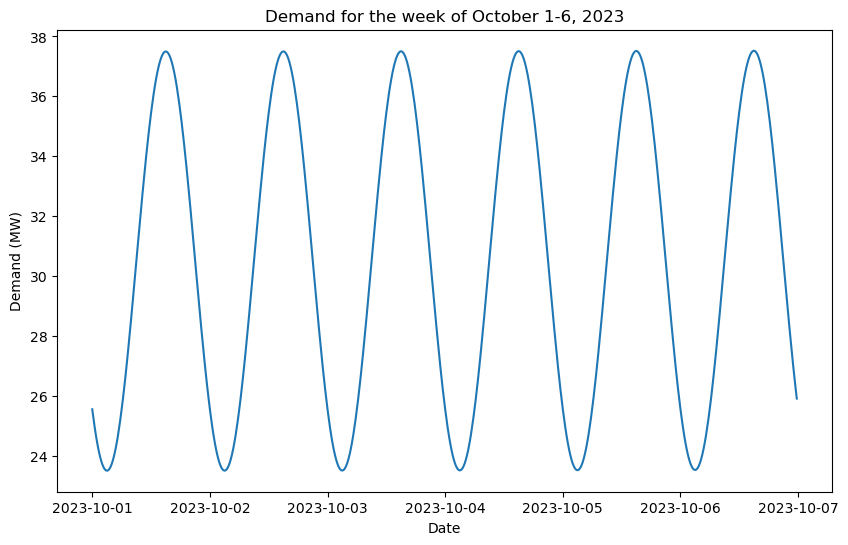

In [1]:
import ElectricityMarket as em

from datetime import datetime, timedelta

# Define the start and end times for the day
start_time = datetime(2023, 10, 1, 0, 0)  
end_time = datetime(2023, 10, 6, 23, 59)

# Define the interval in minutes
interval = 15

time = []
demand = []

# Create a loop to step through the day in 15-minute intervals
current_time = start_time
while current_time <= end_time:
    time.append(current_time)
    demand.append(em.get_demand(current_time))
    current_time += timedelta(minutes=interval)

# Plot the demand
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(time, demand)
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.title('Demand for the week of October 1-6, 2023')
plt.show()

The behavior of an example 10 MW solar generator named `Vulcan` is demonstrated below.  

**Your Task**: Update the capacity function of the `Solar` generator to account for changes in daylight hours and solar intensity.  Daylight ranges from 6 hours in December to 18 hours in June and solar intensity varies from 0.3 in December to 1.0 in June.  `sin` and `cos` functions should be used.

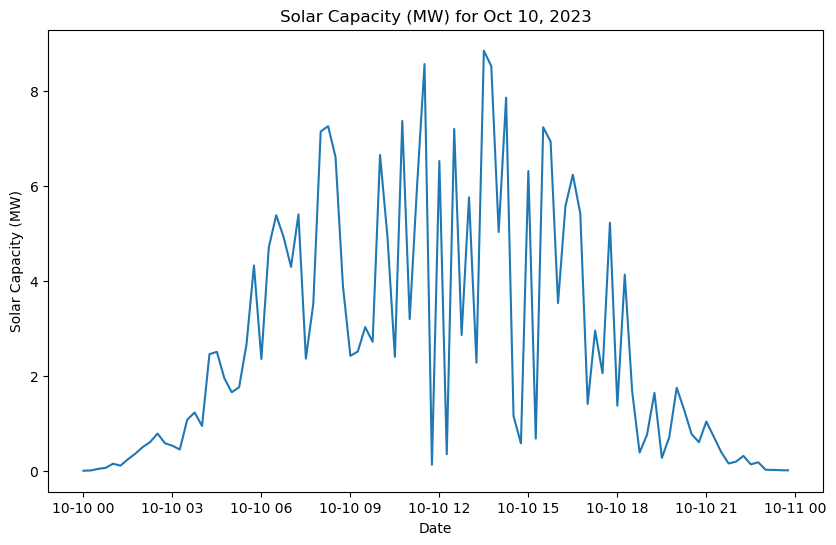

In [2]:
solar = em.Solar('Vulcan', 10)

start_time = datetime(2023, 10, 10, 0, 0)  
end_time = datetime(2023, 10, 10, 23, 59)

# Define the interval in minutes
interval = 15

time = []
solar_capacity = []

# Create a loop to step through the day in 15-minute intervals
current_time = start_time
while current_time <= end_time:
    time.append(current_time)
    (capacity, bid) = solar.bid(current_time)
    solar_capacity.append(capacity)
    current_time += timedelta(minutes=interval)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(time, solar_capacity)
plt.xlabel('Date')
plt.ylabel('Solar Capacity (MW)')
plt.title('Solar Capacity (MW) for Oct 10, 2023')
plt.show()

## Implement the Market
The code below implements a sample market.  It is your task to complete the `ElectricityMarket` module so that the following code works.

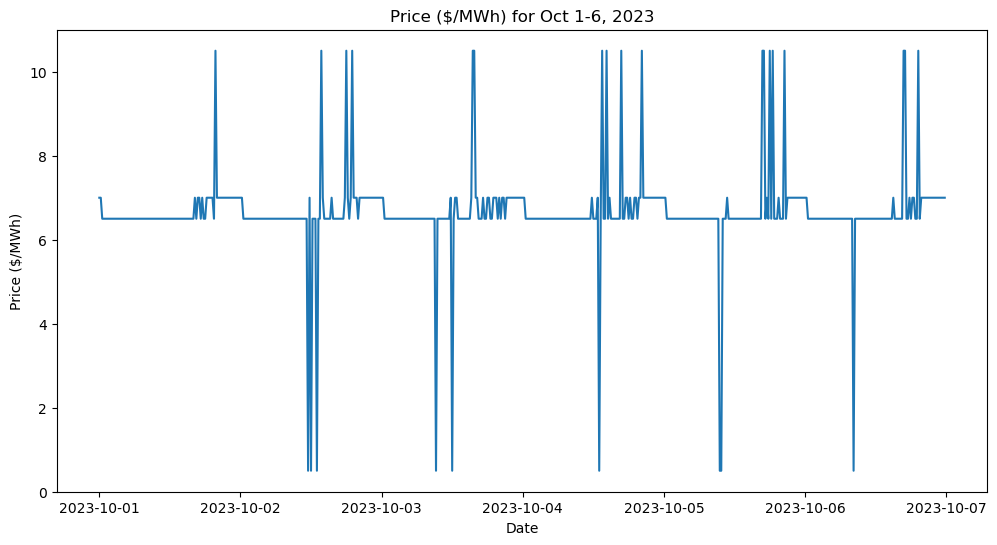

In [3]:
# Define the Market
generators = [
    em.Solar('Vulcan', 22),
    em.Solar('Romulan', 25),
    em.Coal('Klingon', 20),
    em.CCNG('Ferengi', 5), 
    em.NatGasTurbine('Cardassian', 5, fuel_cost=3.5),
    em.NatGasTurbine('Bajoran', 5, fuel_cost=7.5),
    em.NatGasTurbine('Borg', 5, fuel_cost=11.5),
    em.NatGasTurbine('Dominion', 5, fuel_cost=15.5),
    em.NatGasTurbine('Federation', 20, fuel_cost=17.5),
]


start_time = datetime(2023, 10, 1, 0, 0)  
end_time = datetime(2023, 10, 6, 23, 59)

# Define the interval in minutes
interval = 15

# Define the lists to hold the data
time = []
demand_curve = []
price_curve = []

# Create a loop to step through the day in 15-minute intervals
current_time = start_time
while current_time <= end_time:
    time.append(current_time)
    demand = em.get_demand(current_time)
    demand_curve.append(demand)
    
    # Get the current bids for all generators in the market
    bids = {}
    for generator in generators:
        (cap, price) = generator.bid(current_time)
        bids[generator] = (cap, price)
    # sort the bids by price
    generators.sort()


    # Find the market price
    dispatched = 0
    curr_price = 0
    index = 0
    while dispatched < demand:
        dispatched += bids[generators[index]][0]
        curr_price = bids[generators[index]][1]
        index += 1

    # Dispatch the generators
    index = 0
    dispatched = 0
    remaining_demand = demand
    while demand > 0:
        if bids[generators[index]][0] > remaining_demand:
            generators[index].dispatch(bids[generators[index]][0], curr_price)
            demand -= bids[generators[index]][0]
        else:
            generators[index].dispatch(remaining_demand, curr_price)
            demand = 0
        index += 1
    price_curve.append(curr_price)
    current_time += timedelta(minutes=interval)


# Plot the price
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(time, price_curve)
plt.xlabel('Date')
plt.ylabel('Price ($/MWh)')
plt.title('Price ($/MWh) for Oct 1-6, 2023')
plt.show()


## Visualize the Data
For a week in the summer and a week in the winter, create a visual that:
- shows the output vs time for each generator.  Plotting all generators on one plot is best (i.e., a stacked bar or line graph).
- shows prices vs time for the market.
- shows the demand vs time for the market.

Include these plots in your `README.md` file along with a short description of what you did.